In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


In [2]:
# Parameters
epochs = 20
img_width, img_height = 299, 299
batch_size = 2
num_classes = 5
validation_split = 0.2
test_split = 0.1
print("Tets")
data_dir = './../../datasets/dataset1' 


# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split + test_split
)

# Augmentation parameters for specific classes
specific_class_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split + test_split
)

# Generators for training and validation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split / (validation_split + test_split)
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Data preparation for testing
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=test_split / (validation_split + test_split)
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Oversampling the specified minority classes with augmentation
specific_classes = ['1', '2', '3', '4']  # Example specific class indices as strings
oversample_ratio = 2  # How many times to oversample the specific classes

# Create separate generators for the specific classes with augmentation
specific_class_generators = []
for cls in specific_classes:
    specific_class_generator = specific_class_augmentation.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        classes=[cls],
        subset='training',
        shuffle=True
    )
    specific_class_generators.append(specific_class_generator)

# Function to combine generators
def combined_generator(base_generator, specific_class_generators, oversample_ratio):
    while True:
        x_batch, y_batch = base_generator.next()
        for _ in range(oversample_ratio):
            specific_class_index = np.random.randint(len(specific_class_generators))
            x_specific, y_specific = specific_class_generators[specific_class_index].next()
            
            # Ensure y_specific matches the shape of y_batch
            if y_specific.shape[1] == 1:
                y_specific = np.eye(num_classes)[y_specific[:, 0].astype(int)]  # One-hot encode if necessary
                
            x_batch = np.concatenate((x_batch, x_specific), axis=0)
            y_batch = np.concatenate((y_batch, y_specific), axis=0)
        
        yield x_batch, y_batch

# Combined generator for training
combined_train_generator = combined_generator(train_generator, specific_class_generators, oversample_ratio)



Tets
Found 24591 images belonging to 5 classes.
Found 23416 images belonging to 5 classes.
Found 11708 images belonging to 5 classes.
Found 1711 images belonging to 1 classes.
Found 3705 images belonging to 1 classes.
Found 612 images belonging to 1 classes.
Found 496 images belonging to 1 classes.


In [3]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

In [4]:
learning_rate = 3.9e-5
metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [5]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()
    
def show_confusion_matrix(model):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(conf_matrix)

    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, list(test_generator.class_indices.keys()))
    

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 2s 0us/step


In [7]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    combined_train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs,
    batch_size=128
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

train_accuracy->  [0.8767979145050049, 0.8939876556396484, 0.8981630802154541, 0.9012933373451233, 0.9039381742477417, 0.9054145812988281, 0.9074074029922485, 0.9085474014282227, 0.9100521802902222, 0.9117997884750366, 0.9125725030899048, 0.9145393967628479, 0.9154058694839478, 0.9163966774940491, 0.9176574349403381, 0.9192289113998413, 0.920394778251648, 0.9212228059768677, 0.9229027628898621, 0.9241917133331299]
val_accuracy->  [0.6931585073471069, 0.7055432200431824, 0.7347112894058228, 0.6550222039222717, 0.7280492186546326, 0.7335582375526428, 0.743337869644165, 0.7406901121139526, 0.737999677658081, 0.7447471618652344, 0.6606166958808899, 0.7568329572677612, 0.7525623440742493, 0.7516227960586548, 0.7530748248100281, 0.7563631534576416, 0.7588828206062317, 0.7505124807357788, 0.7563204765319824, 0.7388537526130676]
train_loss->  [0.37179914116859436, 0.31903401017189026, 0.3024890720844269, 0.29225072264671326, 0.2840747535228729, 0.2767496109008789, 0.2716202735900879, 0.2653997

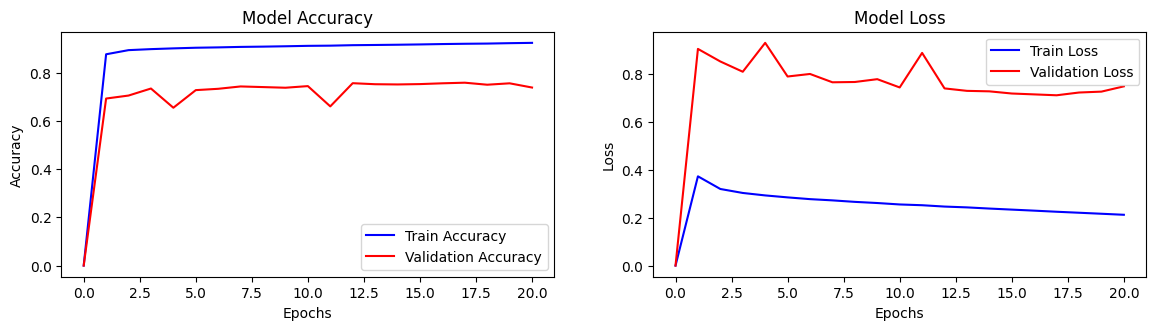

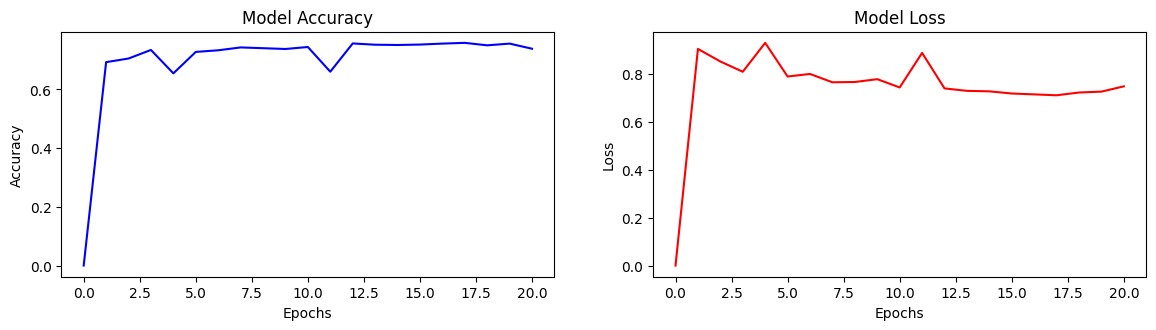

In [8]:
accuracyGraph(history)

5854/5854 [==============================] - 83s 14ms/step
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      8603
           1       0.05      0.06      0.06       814
           2       0.14      0.03      0.05      1764
           3       0.05      0.01      0.02       291
           4       0.01      0.02      0.01       236

    accuracy                           0.64     11708
   macro avg       0.20      0.20      0.19     11708
weighted avg       0.57      0.64      0.59     11708

[[7379  687  272   40  225]
 [ 718   50   29    4   13]
 [1514  143   51    8   48]
 [ 239   32    8    3    9]
 [ 200   26    6    0    4]]


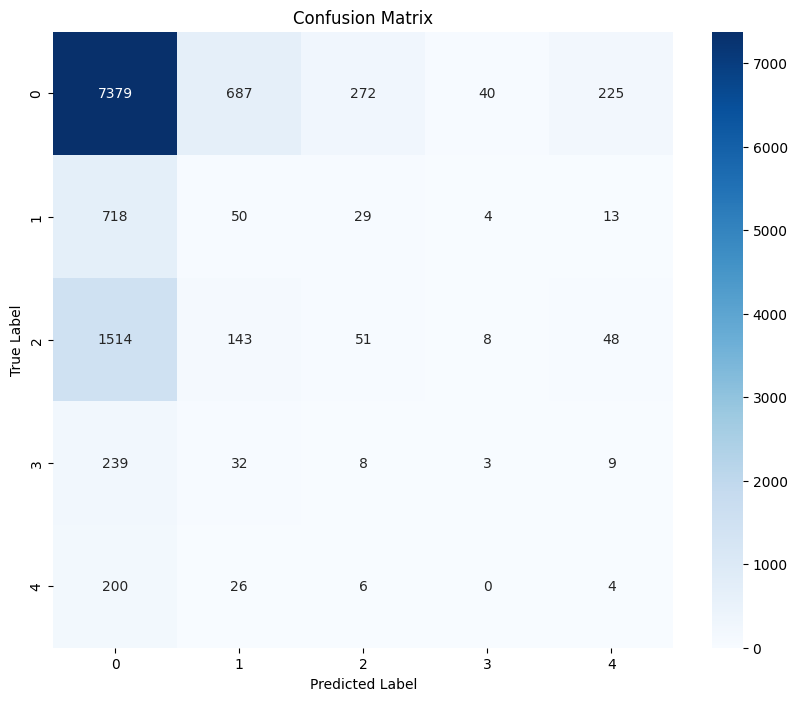

In [9]:
show_confusion_matrix(model)

In [10]:
_metrices = model.evaluate(test_generator)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

5854/5854 [==============================] - 114s 19ms/step - loss: 0.8682 - accuracy: 0.7067 - auc: 0.9066 - balanced_accuracy: 0.7067 - fscore: 0.6373 - precision: 0.7401 - recall: 0.6689
Test Metrices [0.8682193756103516, 0.7066962718963623, 0.9065598845481873, 0.7066962718963623, 0.6372725963592529, 0.7401002049446106, 0.6688588857650757]


In [11]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers[:249]:   
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
# model.compile(optimizer=Adam(lr=0.00001), loss=loss_fn, metrics=['accuracy'])
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)

# Continue training (fine-tuning)
# Train the model
history = model.fit(
    combined_train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

Epoch 1/20


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12296/12296 [==============================] - 936s 76ms/step - loss: 0.2701 - accuracy: 0.9112 - auc: 0.9832 - balanced_accuracy: 0.8567 - fscore: 0.8011 - precision: 0.9010 - recall: 0.8669 - val_loss: 0.7077 - val_accuracy: 0.7605 - val_auc: 0.9330 - val_balanced_accuracy: 0.7605 - val_fscore: 0.7004 - val_precision: 0.7933 - val_recall: 0.7169
Epoch 2/20
12296/12296 [==============================] - 953s 77ms/step - loss: 0.2440 - accuracy: 0.9176 - auc: 0.9918 - balanced_accuracy: 0.8686 - fscore: 0.8129 - precision: 0.9314 - recall: 0.9059 - val_loss: 0.6993 - val_accuracy: 0.7629 - val_auc: 0.9350 - val_balanced_accuracy: 0.7629 - val_fscore: 0.7022 - val_precision: 0.7937 - val_recall: 0.7213
Epoch 3/20
12296/12296 [==============================] - 951s 77ms/step - loss: 0.2295 - accuracy: 0.9218 - auc: 0.9928 - balanced_accuracy: 0.8780 - fscore: 0.8224 - precision: 0.9344 - recall: 0.9106 - val_loss: 0.6528 - val_accuracy: 0.7787 - val_auc: 0.9441 - val_balanced_accuracy: 0

train_accuracy->  [0.9112180471420288, 0.9176438450813293, 0.9218317866325378, 0.9269291162490845, 0.9324612021446228, 0.9402554035186768, 0.9487561583518982, 0.9570121169090271, 0.9647248387336731, 0.9719650149345398, 0.9775367975234985, 0.9804511666297913, 0.9839625954627991, 0.9859551787376404, 0.9871890544891357, 0.98820561170578, 0.9886531829833984, 0.9906051754951477, 0.9908085465431213, 0.9913373589515686]
val_accuracy->  [0.7605056166648865, 0.7628544569015503, 0.7786983251571655, 0.7919371128082275, 0.7936026453971863, 0.8194823861122131, 0.8134181499481201, 0.8366501331329346, 0.8434403538703918, 0.8582593202590942, 0.8643235564231873, 0.8662453293800354, 0.8616330623626709, 0.8636402487754822, 0.8714126944541931, 0.8603519201278687, 0.8665869235992432, 0.8700461387634277, 0.8618893027305603, 0.8625726103782654]
train_loss->  [0.27011096477508545, 0.24400633573532104, 0.22951723635196686, 0.21375960111618042, 0.1944308876991272, 0.17155806720256805, 0.1448490470647812, 0.1200

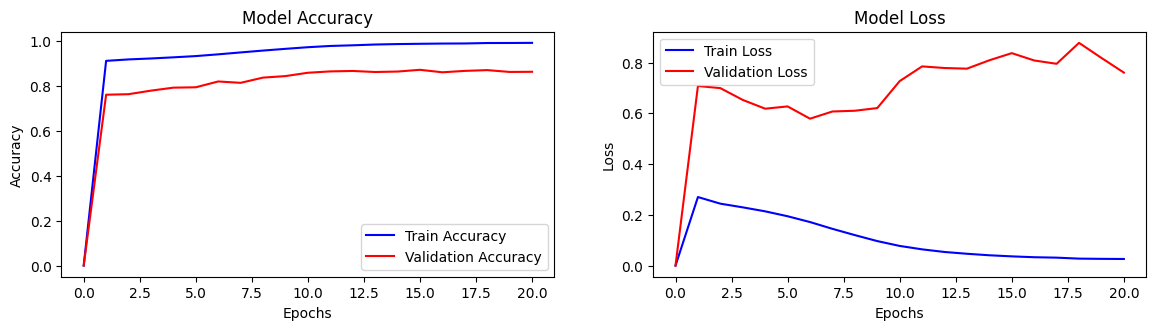

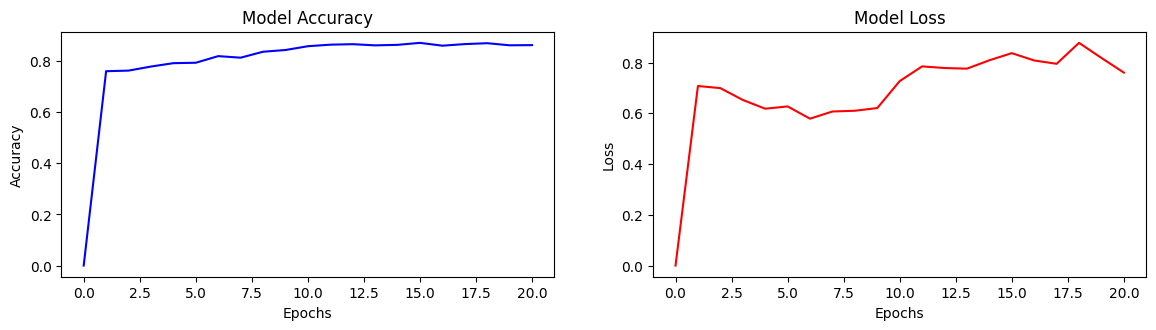

In [12]:
accuracyGraph(history)

5854/5854 [==============================] - 83s 14ms/step
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      8603
           1       0.08      0.06      0.07       814
           2       0.17      0.14      0.16      1764
           3       0.03      0.02      0.02       291
           4       0.02      0.03      0.02       236

    accuracy                           0.60     11708
   macro avg       0.21      0.21      0.21     11708
weighted avg       0.57      0.60      0.59     11708

[[6768  431 1065  146  193]
 [ 640   46   92   12   24]
 [1375   81  252   22   34]
 [ 238    7   33    5    8]
 [ 180   10   35    5    6]]


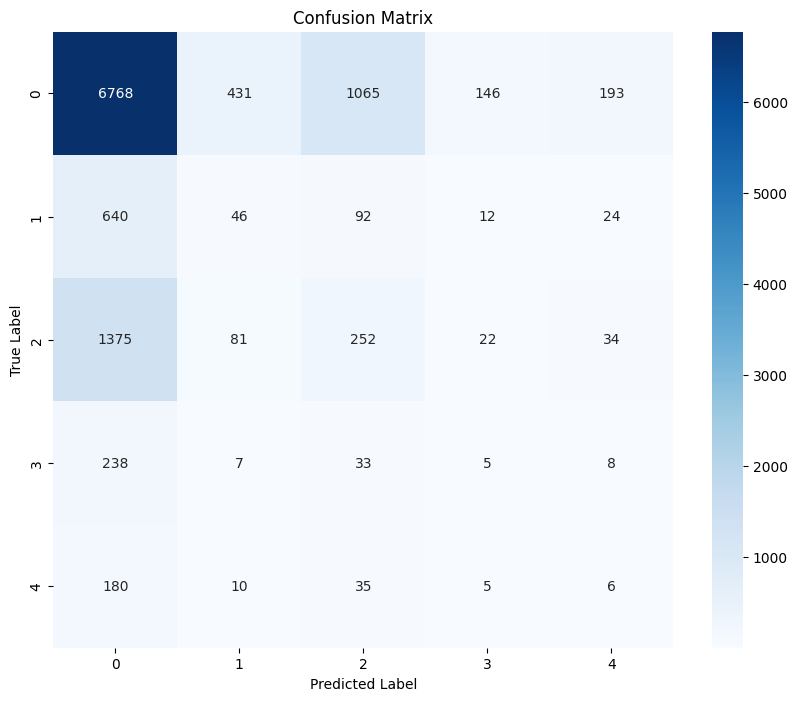

In [13]:
show_confusion_matrix(model)

In [14]:
_metrices = model.evaluate(test_generator)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

5854/5854 [==============================] - 114s 19ms/step - loss: 1.4876 - accuracy: 0.7341 - auc: 0.8985 - balanced_accuracy: 0.7341 - fscore: 0.6695 - precision: 0.7394 - recall: 0.7289
Test Metrices [1.4875587224960327, 0.7341134548187256, 0.8984894752502441, 0.7341134548187256, 0.669501781463623, 0.7393865585327148, 0.7289032936096191]
